<a href="https://colab.research.google.com/github/ShraddhaSharma24/AI-For-Good/blob/main/Chest_X_ray_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install kaggle numpy pandas matplotlib torch torchvision torchmetrics albumentations opencv-python tqdm segmentation_models_pytorch


In [3]:
import os
from google.colab import files

# Upload kaggle.json (Only required once)
print("Please upload your Kaggle API key (kaggle.json)")
files.upload()

# Move it to the correct directory
os.system("mkdir -p ~/.kaggle && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json")

# Download and extract dataset
os.system("kaggle datasets download -d paultimothymooney/chest-xray-pneumonia -p /content/ --unzip")

# Verify dataset extraction
print("Dataset extracted successfully!")


Please upload your Kaggle API key (kaggle.json)


Saving kaggle.json to kaggle.json
Dataset extracted successfully!


In [4]:
import os

DATASET_PATH = "/content/chest_xray/"
TRAIN_PATH = os.path.join(DATASET_PATH, "train")
TEST_PATH = os.path.join(DATASET_PATH, "test")

print("\nTraining Folder:", os.listdir(TRAIN_PATH))
print("\nTesting Folder:", os.listdir(TEST_PATH))



Training Folder: ['PNEUMONIA', 'NORMAL']

Testing Folder: ['PNEUMONIA', 'NORMAL']


In [5]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import glob

# Define dataset class
class XrayDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.image_paths = glob.glob(root_dir + "/*/*.jpeg")  # Load all images
        self.labels = [1 if "PNEUMONIA" in path else 0 for path in self.image_paths]  # Label (1: Pneumonia, 0: Normal)
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Define transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Load datasets
train_dataset = XrayDataset(TRAIN_PATH, transform=transform)
test_dataset = XrayDataset(TEST_PATH, transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Training samples: {len(train_dataset)}, Testing samples: {len(test_dataset)}")


Training samples: 5216, Testing samples: 624


In [6]:
import torch.nn as nn
import torch.optim as optim

# Define CNN model
class PneumoniaCNN(nn.Module):
    def __init__(self):
        super(PneumoniaCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32*32*32, 128)
        self.fc2 = nn.Linear(128, 1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x

# Initialize model
model = PneumoniaCNN()
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [7]:
# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Train function
def train_model(model, dataloader, epochs=5):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for images, labels in dataloader:
            images, labels = images.to(device), labels.float().to(device)
            labels = labels.view(-1, 1)  # Reshape for BCE Loss

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(dataloader):.4f}")

# Train the model
train_model(model, train_loader)


Epoch 1/5, Loss: 0.1737
Epoch 2/5, Loss: 0.0905
Epoch 3/5, Loss: 0.0609
Epoch 4/5, Loss: 0.0494
Epoch 5/5, Loss: 0.0399


In [7]:
def evaluate_model(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            predicted = (outputs > 0.5).float()
            correct += (predicted.view(-1) == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total * 100
    print(f"Model Accuracy: {accuracy:.2f}%")

# Run evaluation
evaluate_model(model, test_loader)


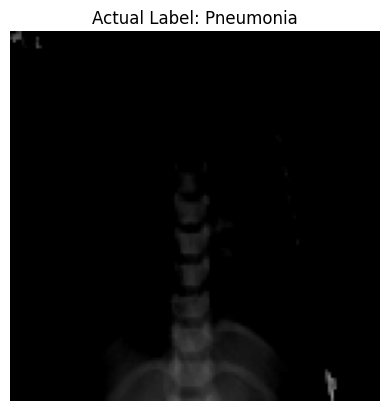

Model Prediction: Pneumonia


In [8]:
import matplotlib.pyplot as plt

# Load a sample image
sample_image, sample_label = test_dataset[0]

# Convert tensor to image
sample_image = sample_image.permute(1, 2, 0).numpy()

# Display the image
plt.imshow(sample_image, cmap="gray")
plt.title(f"Actual Label: {'Pneumonia' if sample_label == 1 else 'Normal'}")
plt.axis("off")
plt.show()

# Predict using model
model.eval()
with torch.no_grad():
    sample_input = sample_image.transpose(2, 0, 1)  # Convert to (C, H, W)
    sample_input = torch.tensor(sample_input).unsqueeze(0).to(device)
    prediction = model(sample_input)
    predicted_label = "Pneumonia" if prediction.item() > 0.5 else "Normal"

print(f"Model Prediction: {predicted_label}")
